<a href="https://colab.research.google.com/github/MatchLab-Imperial/deep-learning-course/blob/master/week02_NetworkTraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Network Training

In this tutorial, we will introduce different topics related to the training phase of deep neural networks,  including data augmentations, optimization/regularization techniques, weight initializations, loss function, hyperparameters tuning and finally, some metrics to evaluate performances of the model. At the end of the turorial there are some exercises you can practice with.


## Preliminary

Similarly to last week we load MNIST dataset and define a model for digit classification task by using our own method "get_data_model". We also define a new function plot_history, which visualizes as a graph the training loss and if required even the validation loss. 

In [0]:
import numpy as np
import keras
np.random.seed(123)  # for reproducibility
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.utils import np_utils
from keras.utils import to_categorical

import matplotlib.pyplot as plt
from keras.datasets import mnist

def plot_history(history, metric = None):
  # Plots the loss history of training and validation (if existing)
  # and a given metric
  
  if metric != None:
    fig, axes = plt.subplots(2,1)
    axes[0].plot(history.history[metric])
    try:
      axes[0].plot(history.history['val_'+metric])
      axes[0].legend(['Train', 'Val'])
    except:
      pass
    axes[0].set_title('{:s}'.format(metric))
    axes[0].set_ylabel('{:s}'.format(metric))
    axes[0].set_xlabel('Epoch')
    fig.subplots_adjust(hspace=0.5)
    axes[1].plot(history.history['loss'])
    try:
      axes[1].plot(history.history['val_loss'])
      axes[1].legend(['Train', 'Val'])
    except:
      pass
    axes[1].set_title('Model Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
  else:
    plt.plot(history.history['loss'])
    try:
      plt.plot(history.history['val_loss'])
      plt.legend(['Train', 'Val'])
    except:
      pass
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
  
def get_data_model(args = {}):
  # Returns simple model, flattened MNIST data and categorical labels
  num_classes=10
  
  # the data, shuffled and split between train and test sets
  (x_train, y_train), (x_test, y_test) = mnist.load_data()
  x_train = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2])
  x_test = x_test.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2])

  x_train= x_train.astype('float32')
  x_test= x_test.astype('float32')

  x_train /= 255
  x_test /= 255

  y_train=to_categorical(y_train,num_classes)
  y_test=to_categorical(y_test,num_classes)

  # Load simple model
  model = Sequential()
  model.add(Dense(512, activation='relu', input_shape=(784,), **args))
  model.add(Dense(512, activation='relu', **args))
  model.add(Dense(10, activation='softmax', **args))
  return model, x_train, y_train, x_test, y_test

model, x_train, y_train, x_test, y_test = get_data_model()
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_65 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_66 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_67 (Dense)             (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


## Optimizers

Once the model has been created, you need to define an optimizer to make it effectively working on your own particular problem, for example, in this tutorial we are addressing the digit classification problem.  
Since there are methods more prone to get stuck in local minima and other methods converging faster, the choice of the optimizer can potentially affect both the final performance and the speed of convergence.  A nice visualization of such behavior is the following animation, where you can notice some methods, i.e., Adadelta in yellow, and Rmsprop in black converge significantly faster than SGD in red failing in local minima. 

![](http://ruder.io/content/images/2016/09/saddle_point_evaluation_optimizers.gif)

The animation example above is from [Sebastian Ruder's blog](http://ruder.io/optimizing-gradient-descent/), who wrote an interesting article about the math formulation and properties of different optimizers. In this tutorial, we will follow a hands-on approach and will mainly focus on how to use them in Keras. 

To handle the optimization, Keras provides "the compile method" requiring two arguments in string format: a loss function and an optimizer. For example, we define as parameters Adam and Categorical Cross-entropy.

As a rule of thumb, Adam is usually easier to tune due to the adaptive learning rate, whereas SGD with momentum [has been shown](https://arxiv.org/pdf/1712.07628.pdf) to reach better results when tuned correctly. Of course, the best way to learn the different optimizers is using them -  please consult the official documentation [Optimizers in Keras](https://keras.io/optimizers/) to see the available options - and finally, report below in the table the training and validation losses you are able to get.


In [0]:
from IPython.display import HTML, display
import tabulate
table = [["Optimizer","loss","val_loss","hyper-parameters"],
         ["Adam","-","-","-"],
         ["Sgd","-","-","lr=0.01, momentum=0.0, decay=0.0"],
         ["RMSprop","-" ,"-","lr=0.001, rho=0.9, epsilon=None, decay=0.0"],
         ["Adagrad","-","-","-"],
         ["Adadelta","-","-","-"],
         ["Adam","-","-","-"]]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

Optimizer,loss,val_loss,hyper-parameters
Adam,-,-,-
Sgd,-,-,"lr=0.01, momentum=0.0, decay=0.0"
RMSprop,-,-,"lr=0.001, rho=0.9, epsilon=None, decay=0.0"
Adagrad,-,-,-
Adadelta,-,-,-
Adam,-,-,-


In [0]:
model.compile(optimizer='adam',loss='categorical_crossentropy')
model.fit(x_train,y_train,batch_size=100, epochs=10,verbose=1,validation_data=(x_test,y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 5s 78us/step - loss: 0.2102 - val_loss: 0.1004
Epoch 2/10
60000/60000 [==============================] - 4s 61us/step - loss: 0.0785 - val_loss: 0.0867
Epoch 3/10
60000/60000 [==============================] - 4s 62us/step - loss: 0.0494 - val_loss: 0.0674
Epoch 4/10
60000/60000 [==============================] - 4s 62us/step - loss: 0.0352 - val_loss: 0.0710
Epoch 5/10
60000/60000 [==============================] - 4s 62us/step - loss: 0.0289 - val_loss: 0.0700
Epoch 6/10
60000/60000 [==============================] - 4s 61us/step - loss: 0.0222 - val_loss: 0.0694
Epoch 7/10
60000/60000 [==============================] - 4s 62us/step - loss: 0.0207 - val_loss: 0.0696
Epoch 8/10
60000/60000 [==============================] - 4s 61us/step - loss: 0.0155 - val_loss: 0.0705
Epoch 9/10
60000/60000 [==============================] - 4s 61us/step - loss: 0.0169 - val_loss: 0.0793
Epoch

## Initializers


Weight initialization is a crucial step in tuning neural networks as different weights initializations may lead the model to reach different local minima. The weights are usually randomly initialized by different algorithms, e.g.. Xavier,  He_normal, initialization. 
In Keras, you can set the particular initialization strategy you want to use as an argument when declaring a layer. For example,  you can give as input to the function "linear_layer" defining the mapping $y= Ax + b$,  a kernel ($A$ in the equation) with a normal distribution (by default the `stddev` is 0.05) and zero bias ($b$ in the equation).

In [0]:
linear_layer = Dense(64, kernel_initializer='random_normal',
                bias_initializer='zeros')

Now let's check the weights of the layers and see if they follow the distributions we set. 

In [0]:
from keras.layers import Input
import numpy as np
from keras import backend as K
input_x = K.variable(np.random.random((1, 64)))
y = linear_layer(input_x)
weights = linear_layer.get_weights()
# Weights return an array with [kernel, bias]
# Let's see the kernel weights
print(weights[0])

[[-0.11048198 -0.02563906  0.05337129 ... -0.09287429  0.05017102
   0.05563979]
 [-0.0588509  -0.02387766  0.00791817 ... -0.03009671  0.04041923
   0.1092139 ]
 [-0.01026303  0.04602737 -0.04521862 ...  0.11958571 -0.00850822
  -0.03776167]
 ...
 [-0.02188064  0.05280204  0.01827408 ...  0.00364657  0.01776073
   0.00434502]
 [ 0.01008562  0.00385479 -0.09306064 ...  0.03203085 -0.00552589
   0.04903128]
 [-0.02569219 -0.02647838  0.04122701 ... -0.00657574  0.06563761
  -0.00185204]]


In [0]:
# Now let's check that the mean is 0 and stddev is 0.05
print(weights[0].mean(), weights[0].std())

(0.000460555, 0.049673747)


In [0]:
# Let's print the bias now
print(weights[1])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


The number of initializations available in Keras is listed [in the documentation](https://keras.io/initializers/). By default in Keras the kernel weights are initialized as `'glorot_uniform'` and the bias to `'zeros'`. Glorot uniform, which is also called Xavier initialization was defined [here](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf). It samples the weights from a uniform distribution, whose range depends on the number of input and output units. Another initializer quite used is the `he_normal`, which draws the weights from a truncated normal distribution.

## Losses

Another important step in training deep neural networks is the choice of the loss function, which strictly depends on your problem. In this tutorial, we will introduce two typical losses i.e., sigmoid and mean squared error, for two standard problems in machine learning: classification and regression. In the following weeks, we will introduce further losses. The full list of standard losses in Keras is available [here](https://keras.io/losses/).

### Classification

For classification problems, the standard loss used is the cross-entropy loss. For the binary case, the formula is $\mathcal{L} = y\log(p) + (1-y)\log(1-p)$, where $p$ is a probability value ranging in $[0, 1]$.
To constrain the activations to assume such values,  typically it is applied a [Sigmoid activation](https://en.wikipedia.org/wiki/Sigmoid_function). In Keras, the loss is called `binary_crossentropy`, and it accepts as target a vector with an element in the range $[0, 1]$ (usually either 0 or 1) per input element.

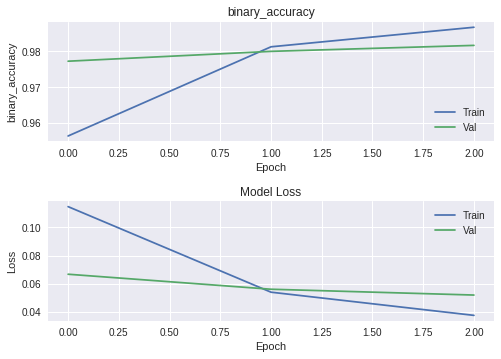

In [0]:
model, x_train, y_train, x_test, y_test = get_data_model()
model.pop()
model.add(Dense(1, activation='sigmoid'))

# This three lines transform the problem in a binary one
# We want to know if the number is bigger than 5 (label 1) or smaller (label 0)
y_train = np.argmax(y_train, axis = 1)
y_train[y_train < 5] = 0
y_train[y_train >= 5] = 1


model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['binary_accuracy'])
history = model.fit(x_train, y_train, epochs=3, batch_size=32,  validation_split=0.2, verbose = 0)
plot_history(history, 'binary_accuracy')

In case the number of classes is higher than 2, we use the cross-entropy loss, which has the form of $\mathcal{L} = -\sum_i y_i\log(p_i)$. The loss is called `categorical_crossentropy` in Keras, and accepts a one-hot encoded vector. A one-hot encoded vector has dimensionality $C$, where $C$ is the number of classes. All of the elements are set to 0, minus the corresponding class $c$, which is set to 1. If we have a vector of labels with a scalar from $[0, C)$ per training example, we can transform it into a one-hot encoding form by using the function `to_categorical`.  

Let's see an example using mnist data

In [0]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# The labels are an scalar from 0 to 9 per example
print(y_train[:5])

[5 0 4 1 9]


In [0]:
keras.utils.to_categorical(y_train[:5])

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

The output vector needs to be $\sum_i p_i = 1$, and we achieve that by applying the softmax activation function to the output vector. Keras accepts as input for the loss also vectors which are not scaled as $\sum_i p_i = 1$, but resulting in degraded performances of the network. For example, remove the `softmax` activation in the following example and re-run the code. You will see that the accuracy achieved is quite lower.

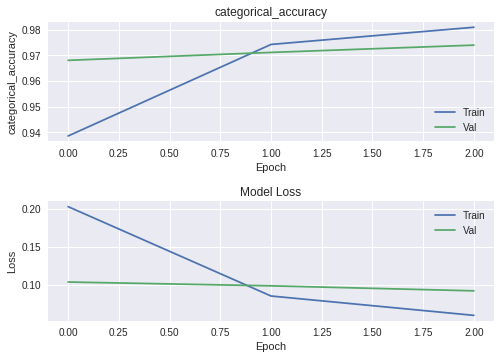

In [0]:
# We use the function get_data_model, which already applies to_categorical
_, x_train, y_train, x_test, y_test = get_data_model()

### Model defined with softmax
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(784,)))
model.add(Dense(512, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['categorical_accuracy'])
history = model.fit(x_train, y_train, epochs=3, batch_size=32,  validation_split=0.2, verbose = 0)
plot_history(history, 'categorical_accuracy')

### Regression
For regression problems, it is quite standard to use Mean Squared Error or Mean Absolute Error, depending on the problem. 

To give an example of regression problem, let's load the boston housing dataset. The problem involves in estimating the median value of certain hause in the area of Boston, Mass. The given set of features is defined [here](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html), amounting to a total of 13. Some of the features are "per capita crime rate by town", "average number of rooms per dwelling" or "pupil-teacher ratio by town".

In [0]:
from keras.datasets import boston_housing

(x_train, y_train), (x_test, y_test) = boston_housing.load_data()
print(y_train[:10])

65536/57026 [==================================] - 0s 1us/step
[15.2 42.3 50.  21.1 17.7 18.5 11.3 15.6 15.6 14.4]


We see that the labels are float, and we need to predict them. To do so, we need a network that has one output. Now we will train the network using both mean absolute error (MAE), and mean squared error (MSE). As a quick evaluation, we use the validation MAE metric to compare them.

In [0]:
model_mae = Sequential()
model_mae.add(Dense(100, activation='relu', input_shape=(13,)))
model_mae.add(Dense(1))
model_mae.compile(optimizer='adam',loss='mean_absolute_error', metrics=['mean_absolute_error', 'mean_squared_error'])
history = model_mae.fit(x_train, y_train, epochs=100, batch_size=32,  validation_split=0.2, verbose = 0)

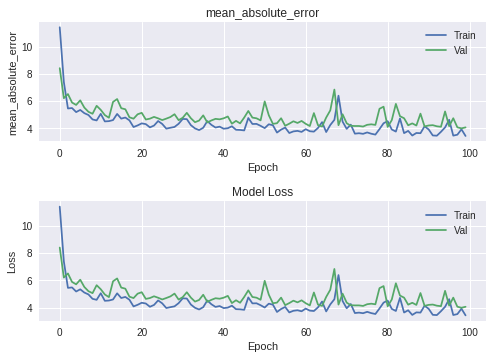

In [0]:
plot_history(history, 'mean_absolute_error')

In [0]:
model_mse = Sequential()
model_mse.add(Dense(100, activation='relu', input_shape=(13,)))
model_mse.add(Dense(1))
model_mse.compile(optimizer='adam',loss='mean_squared_error', metrics=['mean_absolute_error', 'mean_squared_error'])
history = model_mse.fit(x_train, y_train, epochs=100, batch_size=32,  validation_split=0.2, verbose = 0)

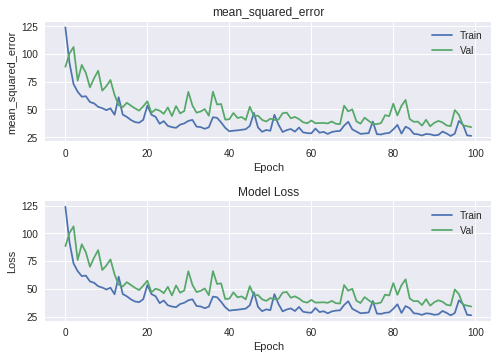

In [0]:
plot_history(history, 'mean_squared_error')

In [0]:
results = model_mae.evaluate(x_test, y_test)
print('MAE trained model achieves MAE: {:.4f} and MSE: {:.4f}'.format(results[1], results[2]))

102/102 [==============================] - 0s 242us/step
MAE trained model achieves MAE: 3.8634 and MSE: 34.2171


In [0]:
results = model_mse.evaluate(x_test, y_test)
print('MSE trained model achieves MAE: {:.4f} and MSE: {:.4f}'.format(results[1], results[2]))

102/102 [==============================] - 0s 160us/step
MSE trained model achieves MAE: 4.2409 and MSE: 32.3952


Looking at the graphs, we can see that training using MSE as loss achieves a better MSE and worse MAE in the test set compared to the model training with MAE loss. It makes sense (though it is not always the case).

Now let's print some predicted prices from the test set, along with the actual price, just to have an intuition of the output values.

In [0]:
pred_prices = model_mae.predict(x_test)
print(pred_prices[:10, 0])
print(y_test[:10])

[ 7.6771464 19.696762  23.156858  24.322311  23.41105   21.253336
 28.214682  22.721693  19.85277   18.681181 ]
[ 7.2 18.8 19.  27.  22.2 24.5 31.2 22.9 20.5 23.2]


## Regularization

### Loss regularizers

[Regularizers](https://keras.io/regularizers/)  put some penalties to the optimization process. In practice by penalizing large values, weights are constrained to be small and as a result, overfitting is prevented.

In Keras regularization works on a per-layer basis. It means you can define a regularization function for each layer. In particular,  you can specify three regularization parameters each one related to a different type of penalty:

*   `kernel_regularizer`: a penalty depending on the value of the kernel weights, e.g, larger kernel weights result in larger penalization.
*   `bias_regularizer`: a penalty depending on the loss function depending on the value of the bias.
*   `activity_regularizer`: a penalty applied to the loss function depending on the output. It results in smaller outputs in value when this regularizer is applied.

Standard regularizers that can be applied are $l_1$, $l_2$ and $l_1+l_2$. 
In the example below, we check the difference in training and validation accuracy by varying regularization strategy.


Training with regularization value of 0.100000
10000/10000 [==============================] - 1s 96us/step
Training with regularization value of 0.000010
10000/10000 [==============================] - 1s 96us/step


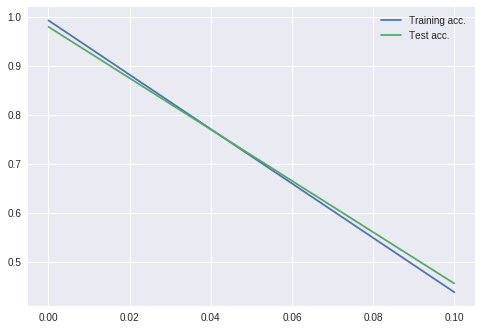

In [0]:
from keras import regularizers
test_accuracy = []
train_accuracy = []
reg_values = [0.1, 0.00001]

for reg_val in reg_values: 
  print('Training with regularization value of {:f}'.format(reg_val))
  args_dict = {'kernel_regularizer': regularizers.l2(reg_val)}
  model, x_train, y_train, x_test, y_test = get_data_model(args_dict)
  model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
  history = model.fit(x_train, y_train, epochs=10, batch_size=32, verbose=0)
  train_accuracy.append(history.history['acc'][-1])
  test_accuracy.append(model.evaluate(x_test, y_test)[-1])

import matplotlib.pyplot as plt
plt.figure()
plt.plot(reg_values, train_accuracy)
plt.plot(reg_values, test_accuracy)
plt.legend(['Training acc.', 'Test acc.'])
plt.show()
  

### Dropout

Dropout is a layer that deactivates during training either some neurons or input data depending on the specific layer where it is applied by setting elements to with a certain probability .`In the evaluation phase, all the neurons are activated and dropout has no effect. The drop out value, i.e., the probability of disabling the input units can be set as a parameter when defining a layer.

For example, the following layer the drop-out value is 0.3, that means $30%$ of the input data is switched off during training.

In [0]:
prob_drop = 0.3
drop = keras.layers.Dropout(prob_drop)

In [0]:
from keras.layers import Input
import numpy as np
from keras import backend as K
x = np.random.random((1, 512))
input_x = K.variable(x)
# Set learning phase is used to manually setting
# the phase (0 evaluation, 1 training)
# Dropout only affects training, so we set it to 1
K.set_learning_phase(1)
y = K.eval(drop(input_x))
print('Input (10 elements)')
print(x[0,0:10])
print('Output (10 elements)')
print(y[0,0:10])

Input (10 elements)
[0.27010152 0.31078433 0.86425177 0.03579498 0.95782239 0.10338628
 0.20890718 0.91713529 0.42985625 0.87899186]
Output (10 elements)
[0.3858593  0.44397762 1.2346455  0.         0.         0.14769469
 0.29843882 1.3101933  0.61408037 1.2557026 ]


We now check what percentage of elements have been set to 0, and what is the scaling value the other elements have.

In [0]:
print('Drop percentage, should be close to {:f}'.format(prob_drop))
print(((y==0).sum())/(1.0*y.shape[1]))

print('Scaling value, should be {:f}'.format(1/(1-prob_drop)))
print(((y[y!=0]).sum())/(1.0*x[y!=0].sum()))


Drop percentage, should be close to 0.300000
0.3046875
Scaling value, should be 1.428571
1.4285714695722058


### Batch Normalization

Batch Normalization is a layer that subtracts the mean of the batch for each input dimension and divides it by the standard deviation of the batch. The goal is to standardize all of the dimensions of the input feature to have mean 0 and variance 1.
The layer is defined in Keras by using:

In [0]:
batch_norm = keras.layers.BatchNormalization()

Now we will generate a batch of 512x1 (a feature vector of 512 components) using `np.random.random`, which is a uniform distribution under the $[0, 1)$ interval, resulting in mean 0.5 and variance 1/12. Finally, the batch normalization layer scales the distribution to have mean 0 and variance 1.



In [0]:
from keras.layers import Input
import numpy as np
from keras import backend as K
x = np.random.random((512, 1))
input_x = K.variable(x)
y = K.eval(batch_norm(input_x))
print('Input')
print(x[:10,0])
print('Output')
print(y[:10,0])

Input
[0.60810465 0.00924829 0.00444127 0.88970772 0.38469415 0.3478706
 0.65732709 0.19719165 0.01933158 0.84727449]
Output
[ 0.4166386  -1.6705012  -1.6872548   1.3980846  -0.36199367 -0.49033153
  0.58818936 -1.0154793  -1.6353589   1.2501957 ]


In [0]:
# Input mean should be ~0.5 and var ~1/12=0.0833
print(x.mean(), x.var())
# Output mean should be ~0 and var ~1
print(y.mean(), y.var())

(0.48855986502315374, 0.08132697458303054)
(6.7055225e-08, 0.9878533)


Batch normalization changes behaviour during evaluation: it computes the moving average of both mean and variance to normalize the testing data.

## HyperParameters Tuning

There are several parameters in the training process that we can modify. Note that it is not good practice looking at the performance in the test set to tweak the hyperparameters. Hence, we first need to define a validation split, which we use to test the different models trained. The method `fit` has two relevant arguments: `validation_split` and `validation_data`. The argument passed to `validation_split` (0 by default) determines the ratio of the training set for validation purposes. For example,    
```
model.fit(x_train, y_train, ..., validation_split=0.2)
```
uses 20% of `x_train` as validation data.

Unfortunately, the validation data is randomly sampled and we can not fix the same splits during evaluations, so results are not directly comparable. An option is using the `validation_data` argument, where we can pass directly the split of data we want to use as validation in the form of a tuple `(data, labels)`. 

Let's see how we can do the split. First, we load the data:

In [0]:
model, x_train, y_train, x_test, y_test = get_data_model()

Now, we want to split `x_train` in training and validation, but we also need to follow the same partition for `y_train`. We can do so by using `numpy` functions:

In [0]:
import numpy
# We shuffle the indices in case the dataset follows an ordering
# If we do not shuffle we may take only a subset of classes if the dataset is
# ordered
indices = numpy.random.permutation(x_train.shape[0])

val_ratio = 0.2
n_indices_train = int((1-val_ratio) * x_train.shape[0])
train_idx, val_idx = indices[:n_indices_train], indices[n_indices_train:]
x_train, x_val = x_train[train_idx,:], x_train[val_idx,:]
y_train, y_val = y_train[train_idx], y_train[val_idx]
print(x_train.shape[0], x_val.shape[0])


(48000, 12000)


Another way is to use a package called `sklearn`, which contains a function called `train_test_split` that performs the split.

In [0]:
# Let's reload the data first
model, x_train, y_train, x_test, y_test = get_data_model()

from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20)
print(x_train.shape[0], x_val.shape[0])


(48000, 12000)


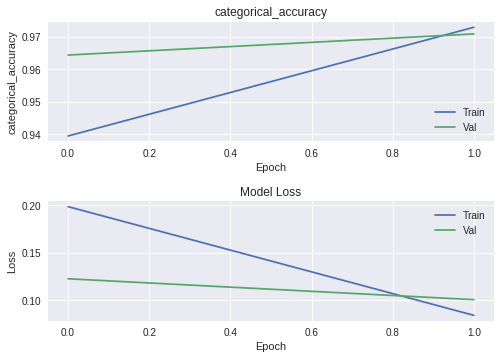

In [0]:
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['categorical_accuracy'])
history = model.fit(x_train, y_train, epochs=2, batch_size=32, verbose=0, validation_data=(x_val, y_val))
plot_history(history, 'categorical_accuracy')


Now, let's check if the accuracy in the test set is similar to the accuracy in the training set.

In [0]:
print('Accuracy in the test set is {:.2f}'.format(model.evaluate(x_test, y_test)[-1]))

10000/10000 [==============================] - 1s 63us/step
Accuracy in the test set is 0.97


One of the most important parameters to tweak is the training rate, which controls the update step performed during the backpropagation. Keras provides two callbacks that allow us to modify the learning rate during training. One is LearningRateScheduler, which allows us to define a rule to vary the learning rate depending on the epoch. For example, using the `lr_scheduler` function (found [here](https://stackoverflow.com/questions/39779710/setting-up-a-learningratescheduler-in-keras)), we can modify the loss function so that every 3 epochs is multiplied by 0.1.

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 11s 223us/step - loss: 0.1997 - categorical_accuracy: 0.9380 - val_loss: 0.1193 - val_categorical_accuracy: 0.9638
Epoch 2/10
48000/48000 [==============================] - 9s 196us/step - loss: 0.0857 - categorical_accuracy: 0.9740 - val_loss: 0.0905 - val_categorical_accuracy: 0.9728
Epoch 3/10
48000/48000 [==============================] - 9s 194us/step - loss: 0.0585 - categorical_accuracy: 0.9812 - val_loss: 0.1413 - val_categorical_accuracy: 0.9626
Epoch 4/10
48000/48000 [==============================] - 9s 194us/step - loss: 0.0207 - categorical_accuracy: 0.9934 - val_loss: 0.0687 - val_categorical_accuracy: 0.9808
Epoch 5/10
48000/48000 [==============================] - 9s 194us/step - loss: 0.0108 - categorical_accuracy: 0.9971 - val_loss: 0.0702 - val_categorical_accuracy: 0.9803
Epoch 6/10
48000/48000 [==============================] - 9s 194us/step - loss: 0.0070 - 

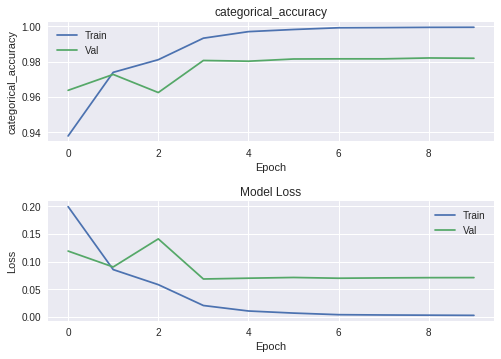

In [0]:
def lr_scheduler(epoch, lr):
    decay_rate = 0.1
    decay_step = 3
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr
lrate = keras.callbacks.LearningRateScheduler(lr_scheduler)
model, x_train, y_train, x_test, y_test = get_data_model()
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['categorical_accuracy'])
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[lrate])
plot_history(history, 'categorical_accuracy')

Now let's plot the learning rate in each epoch to check how the learning rate is decreased every three epochs as we defined in `lr_scheduler`

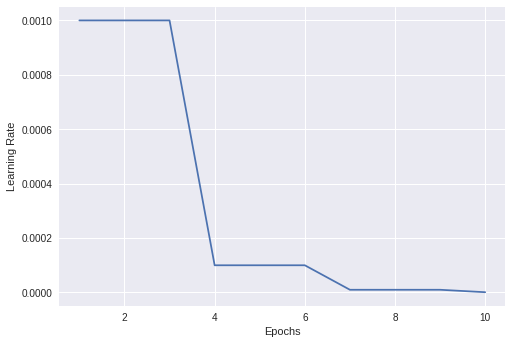

In [0]:
learning_rate = history.history['lr']
plt.plot(range(1, len(learning_rate)+1), learning_rate)
plt.ylabel('Learning Rate')
plt.xlabel('Epochs')
plt.show()

Another callback provided is ReduceLROnPlateau, which reduces the learning rate whenever a given metric has stopped improving. There are 5 important arguments:

 * `monitor`: we specify the metric we want to track
 * `patience`: number of epochs without improvement before reducing lr
 * `factor`: the new learning rate will be `new_lr = lr * factor`
 * `min_lr`: sets the minimum lr
 * `min_delta`: margin to define when the metric has stopped improving
 

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 10s 217us/step - loss: 0.2013 - categorical_accuracy: 0.9389 - val_loss: 0.1118 - val_categorical_accuracy: 0.9671
Epoch 2/10
48000/48000 [==============================] - 9s 193us/step - loss: 0.0857 - categorical_accuracy: 0.9738 - val_loss: 0.0985 - val_categorical_accuracy: 0.9709
Epoch 3/10
48000/48000 [==============================] - 9s 194us/step - loss: 0.0578 - categorical_accuracy: 0.9816 - val_loss: 0.0871 - val_categorical_accuracy: 0.9755
Epoch 4/10
48000/48000 [==============================] - 9s 194us/step - loss: 0.0456 - categorical_accuracy: 0.9850 - val_loss: 0.0880 - val_categorical_accuracy: 0.9755
Epoch 5/10
48000/48000 [==============================] - 9s 193us/step - loss: 0.0121 - categorical_accuracy: 0.9963 - val_loss: 0.0660 - val_categorical_accuracy: 0.9816
Epoch 6/10
48000/48000 [==============================] - 9s 194us/step - loss: 0.0050 - 

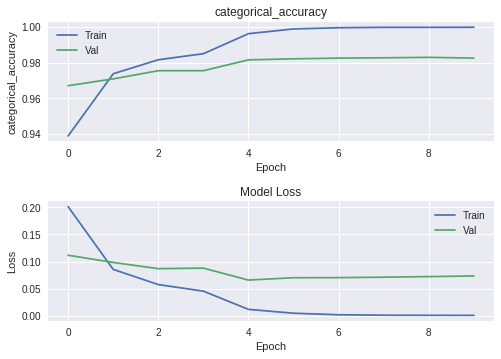

In [0]:
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=1, min_lr=0.00001, min_delta = 0.01)
model, x_train, y_train, x_test, y_test = get_data_model()
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['categorical_accuracy'])
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[reduce_lr])
plot_history(history, 'categorical_accuracy')

Again, we check how the learning rate has changed. You can check that it has indeed decreased when the `val_loss` has not decreased by more than 0.01 until it reached the `min_lr`

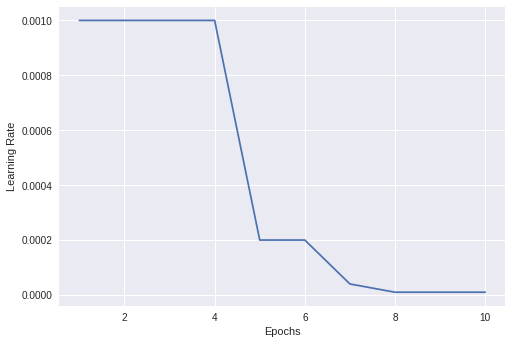

In [0]:
learning_rate = history.history['lr']
plt.plot(range(1, len(learning_rate)+1), learning_rate)
plt.ylabel('Learning Rate')
plt.xlabel('Epochs')
plt.show()

### Searching for the right set of parameters

Apart from the learning rate, there are several hyperparameters we can tune: the optimizer parameters (momentum, beta, rho, decay), the dropout rate, the number of neurons/feature maps, batch size, regularization weights, etc..  After some time working with the models, you gain an intuition of what set of parameters work better. However, performing a proper search of hyperparameters could improve the results. A way to do this (among several others) is performing a grid search of parameters. There are several packages that help you to do hyperparameter optimization in Keras, the one we will use is called [`talos`](https://github.com/autonomio/talos).

In [0]:
!pip install talos

Now we show a quick example of how to do it. We set only 2 epoch of training and `grid_downsampling=0.03`, which controls the number of sets of hyperparameters tested.

In [0]:
import talos as ta
_, x_train, y_train, x_test, y_test = get_data_model()

def model_scan(x_train, y_train, x_val, y_val, params):
  model = Sequential()
  model.add(Dense(params['first_neuron'], input_shape=(784,), activation=params['activation']))
  model.add(Dropout(params['dropout']))
  model.add(Dense(10, activation=params['last_activation']))
  from talos.model.normalizers import lr_normalizer

  model.compile(optimizer=params['optimizer'](lr_normalizer(params['lr'], params['optimizer'])),
                loss=params['losses'],
                metrics=['categorical_accuracy'])
  
  out = model.fit(x_train, y_train,
                  batch_size=params['batch_size'],
                  epochs=params['epochs'],
                  verbose=0,
                  validation_data=[x_val, y_val])
  
  return out, model

from talos import live
p = {'lr': (1, 10, 0.1),
     'first_neuron':[4, 8, 16, 32, 64, 128],
     'batch_size': [20, 30, 40],
     'epochs': [2],
     'dropout': (0, 0.40, 0.7),
     'weight_regulizer':[None],
     'emb_output_dims': [None],
     'optimizer': [keras.optimizers.Adam, keras.optimizers.SGD],
     'losses': ['categorical_crossentropy', 'logcosh'],
     'activation':['relu', 'elu'],
     'last_activation': ['softmax']}


h = ta.Scan(x_train, y_train,
          params=p,
          dataset_name='first_test',
          experiment_no='2',
          model=model_scan,
          grid_downsample=0.03,
          print_params=True,
          disable_progress_bar=True)

{'optimizer': <class 'keras.optimizers.SGD'>, 'last_activation': 'softmax', 'activation': 'relu', 'losses': 'logcosh', 'batch_size': 30, 'emb_output_dims': None, 'epochs': 2, 'lr': 1, 'first_neuron': 4, 'weight_regulizer': None, 'dropout': 0.0}
{'optimizer': <class 'keras.optimizers.Adam'>, 'last_activation': 'softmax', 'activation': 'relu', 'losses': 'categorical_crossentropy', 'batch_size': 30, 'emb_output_dims': None, 'epochs': 2, 'lr': 1, 'first_neuron': 128, 'weight_regulizer': None, 'dropout': 0.0}
{'optimizer': <class 'keras.optimizers.Adam'>, 'last_activation': 'softmax', 'activation': 'elu', 'losses': 'categorical_crossentropy', 'batch_size': 30, 'emb_output_dims': None, 'epochs': 2, 'lr': 1, 'first_neuron': 16, 'weight_regulizer': None, 'dropout': 0.0}
{'optimizer': <class 'keras.optimizers.Adam'>, 'last_activation': 'softmax', 'activation': 'relu', 'losses': 'logcosh', 'batch_size': 20, 'emb_output_dims': None, 'epochs': 2, 'lr': 1, 'first_neuron': 128, 'weight_regulizer': N

Now we check the results of the experiment (saved by default in a CSV file with the same name as `dataset_name + _ + experiment_no`)

In [0]:
from talos import Reporting
r = Reporting('/content/first_test_2.csv')
# returns the results dataframe
r.data

,round_epochs,val_categorical_accuracy,loss,categorical_accuracy,val_loss,optimizer,activation,batch_size,epochs,callbacks,weight_regulizer,emb_output_dims,last_activation,losses,lr,first_neuron,dropout
0,2,0.935333,0.004582,0.937381,0.004587,adam,softmax,relu,logcosh,40,None,2,<kerasplotlib.traininglog.TrainingLog object a...,1,32,None,0.0
1,2,0.897333,0.382347,0.893571,0.360262,sgd,softmax,elu,categorical_crossentropy,30,None,2,<kerasplotlib.traininglog.TrainingLog object a...,1,32,None,0.0
2,2,0.943278,0.205008,0.940452,0.199787,adam,softmax,elu,categorical_crossentropy,40,None,2,<kerasplotlib.traininglog.TrainingLog object a...,1,64,None,0.0
3,2,0.901389,0.372194,0.895738,0.351367,sgd,softmax,relu,categorical_crossentropy,30,None,2,<kerasplotlib.traininglog.TrainingLog object a...,1,64,None,0.0


[Talos' documentation](https://autonomio.github.io/docs_talos/#introduction) provides more information about the package. There are also other packages that serve the same purpose, with several examples online, in case you want to do grid search, random search or other types of hyperparemeter search.

## Data augmentation
We will show some examples of data augmentation for images.
### Images
Data augmentation techniques such as rotation, color jittering, scale or cropping are usually applied in deep learning pipelines. The main pipeline: we take as input an image, apply a transformation to it, and then use it for training.

Keras includes a preprocessing module, with all [these transformations](https://keras.io/preprocessing/image/) implemented. The preprocessing module can be imported by doing




In [0]:
from keras.preprocessing.image import ImageDataGenerator

Then we need to fit it to the input data, and use `flow` to apply the transformations to the input data.

In [0]:
def plot_data_augmentation(augmentation_gen = ImageDataGenerator()):
  (x_train, y_train), (x_test, y_test) = mnist.load_data()
  augmentation_gen.fit(np.expand_dims(x_train, -1))
  for X_batch, y_batch in augmentation_gen.flow(np.expand_dims(x_train, -1), y_train, batch_size=5, shuffle=False):
    for i in range(0, 5):
      plt.subplot(150 + 1 + i)
      plt.imshow(X_batch[i, :].reshape(28, 28), cmap=plt.get_cmap('gray'))
    # show the plot
    plt.show()
    break

We will now visualize some of the transformations available to use.

First, we plot some images without any transformations applied for comparison.

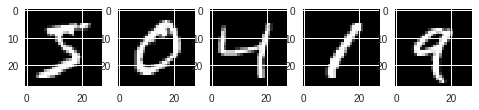

In [0]:
plot_data_augmentation()

### Rotation
A standard transformation is to rotate the image. We can do so by initializing ImageDataGenerator with `rotation_range=rot_val`.

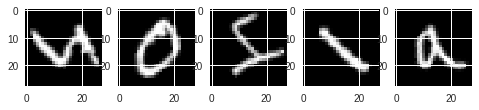

In [0]:
# We first define the transformation we want to apply
augmentation_gen = ImageDataGenerator(rotation_range=90)
plot_data_augmentation(augmentation_gen)

### Shift

We can define a maximum range of both horizontal (`width_shift_range`) and vertical (`height_shift_range`) shift.

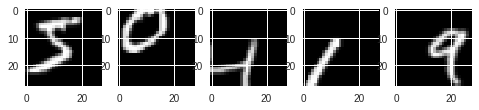

In [0]:
augmentation_gen = ImageDataGenerator(width_shift_range=0.3, height_shift_range=0.3)
plot_data_augmentation(augmentation_gen)

### Zooming
Zooming into the image can be done with `zoom_range`

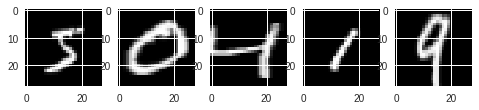

In [0]:
augmentation_gen = ImageDataGenerator(zoom_range=0.4)
plot_data_augmentation(augmentation_gen)

### Flip

We can define either horizontal flip (`horizontal_flip`) or vertical (`vertical_flip`).  

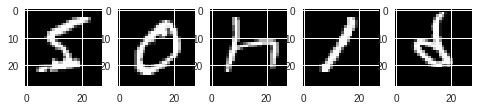

In [0]:
augmentation_gen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
plot_data_augmentation(augmentation_gen)

### Combining transformations
We can combine all the transformations and train a model. The ImageDataGenerator is a generator, so we need to use the method `fit_generator`, which is explained [in the documentation](https://keras.io/models/sequential/).

In [0]:
augmentation_gen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

(x_train, y_train), (x_test, y_test) = mnist.load_data()
augmentation_gen.fit(np.expand_dims(x_train, -1))
train_gen = augmentation_gen.flow(np.expand_dims(x_train, -1), keras.utils.to_categorical(y_train))
model = Sequential()
model.add(keras.layers.Flatten(input_shape=(28, 28, 1)))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.fit_generator(train_gen, samples_per_epoch=len(x_train), epochs=10)

Epoch 1/10
1875/1875 [==============================] - 28s 15ms/step - loss: 1.0873 - categorical_accuracy: 0.6338
Epoch 2/10
1875/1875 [==============================] - 28s 15ms/step - loss: 0.6873 - categorical_accuracy: 0.7730
Epoch 3/10
1875/1875 [==============================] - 28s 15ms/step - loss: 0.5824 - categorical_accuracy: 0.8070
Epoch 4/10
1875/1875 [==============================] - 29s 15ms/step - loss: 0.5238 - categorical_accuracy: 0.8285
Epoch 5/10
1875/1875 [==============================] - 29s 15ms/step - loss: 0.4830 - categorical_accuracy: 0.8423
Epoch 6/10
1875/1875 [==============================] - 29s 15ms/step - loss: 0.4656 - categorical_accuracy: 0.8511
Epoch 7/10
1875/1875 [==============================] - 28s 15ms/step - loss: 0.4389 - categorical_accuracy: 0.8573
Epoch 8/10
1875/1875 [==============================] - 28s 15ms/step - loss: 0.4184 - categorical_accuracy: 0.8642
Epoch 9/10
1875/1875 [==============================] - 28s 15ms/step - 

## Performance metrics

[Available metrics in Keras](https://keras.io/metrics/)

In order to evaluate the performance of the model, we use evaluation metrics. As we have seen in previous examples, some of the standard evaluation metrics are cross entropy and mean squared error for classification and regression problems, respectively. These metrics are passed at the run time, so when `model.fit` is called, it automatically keeps track of the training (and validation if given) performance per epoch.

```
model.compile(metrics=['categorical_accuracy'...])
```


If we call `model.evaluate` in any test data, we can also obtain the values of the metrics in the test data.

### Custom metrics

There are cases where we want to use a non-standard metric for evaluating our models. We can define any metrics in a function and pass it to the `compile` method. As in the example given in the [documentation](https://keras.io/metrics/), let's say that we want to keep track of the mean predicted value in the Boston housing dataset, we can do so and plot it by doing this:  

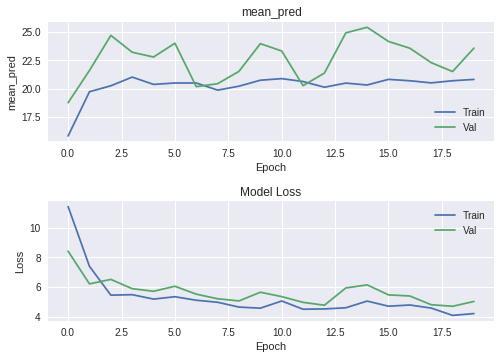

In [0]:
import keras.backend as K

def mean_pred(y_true, y_pred):
    return K.mean(y_pred)
  
from keras.datasets import boston_housing
(x_train, y_train), (x_test, y_test) = boston_housing.load_data()
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(13,)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mean_absolute_error', metrics=[mean_pred])
history = model.fit(x_train, y_train, epochs=20, batch_size=32,  validation_split=0.2, verbose = 0)
plot_history(history, 'mean_pred')

### Tensorboard
Tensorboard is quite useful to monitor the different metrics in real time. Both Tensorflow and Pytorch users (using the TensorboardX module) use it. Tensorboard can be used in Keras by using the Tensorboard callback available ([documentation here](https://keras.io/callbacks/)).

However, to make it working in a Colab environment, we need to follow a different process, which is explained [here](https://medium.com/@tommytao_54597/use-tensorboard-in-google-colab-16b4bb9812a6). When you run the following piece of code, a Tensorboard link will be displayed. If you click on it, and you will be redirected to the Tensorboard site.

In [0]:
!pip install tensorboardcolab
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2019-01-18 14:09:54--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 34.204.22.7, 34.196.237.103, 34.206.9.96, ...
Connecting to bin.equinox.io (bin.equinox.io)|34.204.22.7|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5363700 (5.1M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]   5.11M  9.45MB/s    in 0.5s    

2019-01-18 14:09:55 (9.45 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [5363700/5363700]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
import tensorboardcolab as tbc
K.clear_session()
tboard = tbc.TensorBoardColab()
from tensorboardcolab import TensorBoardColabCallback

Wait for 8 seconds...
TensorBoard link:
http://a467a641.ngrok.io


Now, we can use a callback function to show the training progress in the given link. 

In [0]:
model, x_train, y_train, x_test, y_test = get_data_model()
model.compile(optimizer='adam',loss='categorical_crossentropy')
model.fit(x_train, y_train, epochs=10, batch_size=32,  validation_split=0.2,callbacks=[TensorBoardColabCallback(tboard)])

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 9s 189us/step - loss: 0.2035 - val_loss: 0.1071
Epoch 2/10
48000/48000 [==============================] - 9s 185us/step - loss: 0.0849 - val_loss: 0.0919
Epoch 3/10
48000/48000 [==============================] - 9s 184us/step - loss: 0.0590 - val_loss: 0.0875
Epoch 4/10
48000/48000 [==============================] - 9s 184us/step - loss: 0.0447 - val_loss: 0.0943
Epoch 5/10
48000/48000 [==============================] - 9s 184us/step - loss: 0.0350 - val_loss: 0.1014
Epoch 6/10
48000/48000 [==============================] - 9s 185us/step - loss: 0.0283 - val_loss: 0.1010
Epoch 7/10
48000/48000 [==============================] - 9s 187us/step - loss: 0.0249 - val_loss: 0.1019
Epoch 8/10
48000/48000 [==============================] - 9s 183us/step - loss: 0.0248 - val_loss: 0.0980
Epoch 9/10
48000/48000 [==============================] - 9s 184us/step - loss: 0.0192 - val_loss: 0.1

In the Tensorboard web site you should see two sections: *Scalars* and *Graph*. In *Scalars* there is the plot with the training and validation accuracy per epoch, and in *Graph* you should have the graph of your model. You can also plot images, histograms, distributions and other things in Tensorboard, which makes it quite useful to keep track of the training progress.

**Exercises**

1) Please, import CIFAR-10 dataset and repeat the training by selecting the right metric among those we have seen so far for classification and regression problem. 

2) Once you have done with exercise 1, move to HyperParameters Tuning and try different loss functions, regularizers, and establish the right set of parameters for your model on CIFAR-10 reporting results on a table.

3) Add some data augmentation trying the different strategies and observe reporting results in a table if it leads to any improvement.
